In [1]:
%load_ext autoreload
%autoreload 2   

In [2]:
import numpy as np
import random
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os

seed = 0
np.random.seed(seed)
random.seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import sys
import torchvision

sys.path.append("../")
from mftma.manifold_analysis_correlation import manifold_analysis_corr
from mftma.utils.make_manifold_data import make_manifold_data
from mftma.utils.activation_extractor import extractor
from mftma.utils.analyze_pytorch import analyze

In [4]:
from avalanche.training import Naive, EWC
from avalanche.checkpointing import maybe_load_checkpoint, save_checkpoint

/home/anirudh/ManifoldCapacityCL/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import glob
from natsort import natsorted
import run_utils


project_name = "naive_CIFAR100"
weight_files = natsorted(glob.glob(f"./results/{project_name}/*.pth"))

In [6]:
# Config
metrics = {}

for i in range(len(weight_files)):
    print(i, weight_files[i])

    model = torchvision.models.resnet18(num_classes=100).to(device)

    # Prepare for training & testing
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    # optimizer = Adam(model.parameters(), lr=0.01)
    criterion = CrossEntropyLoss()

    # Continual learning strategy
    cl_strategy = Naive(
        model,
        optimizer,
        criterion,
        # ewc_lambda=0.1,
        train_mb_size=2048,
        train_epochs=100,
        eval_mb_size=32,
        device=device,
    )

    cl_strategy, initial_exp = maybe_load_checkpoint(cl_strategy, weight_files[i])

    capacities, radii, dimensions, correlations, names = run_utils.get_manifold_metrics(
        model
    )

    metrics.update(
        {
            f"task_{i}": {
                "capacities": capacities,
                "radii": radii,
                "dimensions": dimensions,
                "correlations": correlations,
                "names": names,
            }
        }
    )

    if not os.path.exists(f"./plots/{project_name}"):
        os.makedirs(f"./plots/{project_name}")

    torch.save(metrics, f"./plots/{project_name}/naive_CIFAR100_metrics.pth")
    break

0 ./results/naive_CIFAR100/0_checkpoint.pth


/home/anirudh/ManifoldCapacityCL/.venv/lib/python3.10/site-packages/avalanche/training/templates/base.py:468: PositionalArgumentsDeprecatedWarning: Avalanche is transitioning to strategy constructors that accept named (keyword) arguments only. This is done to ensure that there is no confusion regarding the meaning of each argument (strategies can have many arguments). Your are passing 3 positional arguments to the Naive.__init__ method. Consider passing them as names arguments. The ability to pass positional arguments will be removed in the future.
  warnings.warn(error_str, category=PositionalArgumentsDeprecatedWarning)


Mapping cuda:0 to cuda:0
[InteractiveLogger] Resuming from checkpoint. Current time is 2024-05-02 09:05:34 -0700
Files already downloaded and verified
Files already downloaded and verified
Projecting layer_1_Conv2d
layer_0_Input capacity: 0.039560, radius 1.578941, dimension 35.059329, correlation 0.329635
layer_1_Conv2d capacity: 0.039545, radius 1.583176, dimension 34.991223, correlation 0.332228
layer_5_Conv2d capacity: 0.041681, radius 1.521950, dimension 34.097471, correlation 0.314004
layer_8_Conv2d capacity: 0.041106, radius 1.526543, dimension 34.355102, correlation 0.317882
layer_10_Conv2d capacity: 0.041453, radius 1.510889, dimension 34.249590, correlation 0.308219


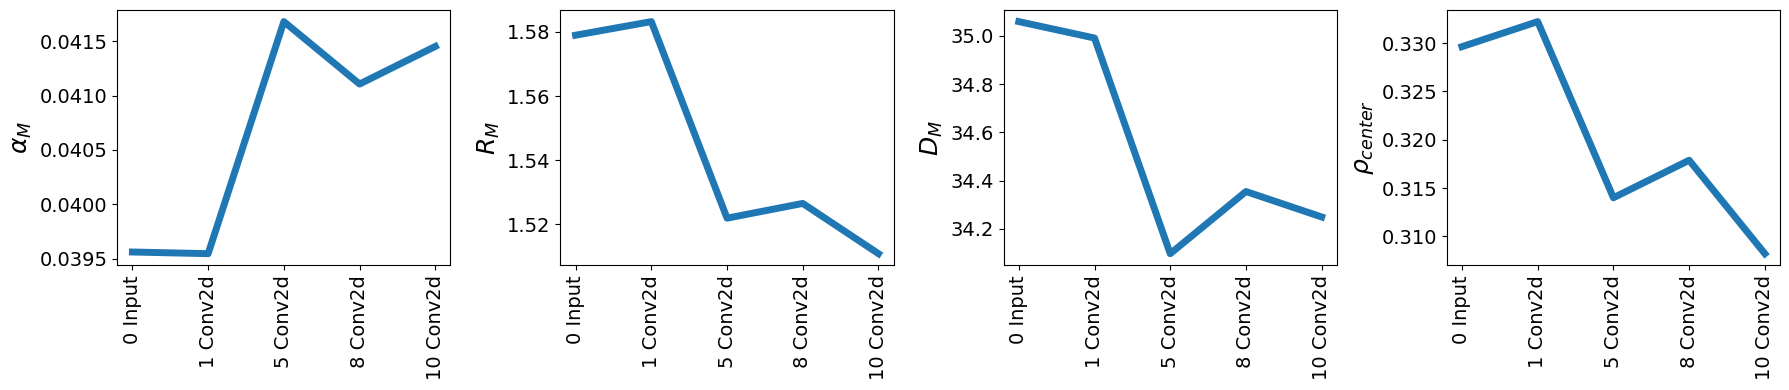

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

axes[0].plot(capacities, linewidth=5)
axes[1].plot(radii, linewidth=5)
axes[2].plot(dimensions, linewidth=5)
axes[3].plot(correlations, linewidth=5)

axes[0].set_ylabel(r"$\alpha_M$", fontsize=18)
axes[1].set_ylabel(r"$R_M$", fontsize=18)
axes[2].set_ylabel(r"$D_M$", fontsize=18)
axes[3].set_ylabel(r"$\rho_{center}$", fontsize=18)

# names = list(activations.keys())
names = [n.split("_")[1] + " " + n.split("_")[2] for n in names]
for ax in axes:
    ax.set_xticks([i for i, _ in enumerate(names)])
    ax.set_xticklabels(names, rotation=90, fontsize=16)
    ax.tick_params(axis="both", which="major", labelsize=14)

plt.tight_layout()
plt.show()